In [1]:
import matplotlib.pyplot as plt
# plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8) # set default size of plots

In [2]:
from matplotlib.colors import ListedColormap

In [3]:
import os
import time

In [4]:
import numpy as np
np.random.seed(42)
np.set_printoptions(precision=5)
np.set_printoptions(suppress=True)

In [5]:
from keras.datasets import cifar10
from random import randrange
import time

C:\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Полносвязная нейронная сеть
В данном домашнем задании вы подготовите свою реализацию двухслойной полносвязной нейронной сети и обучите классификатор на датасете CIFAR-10. Вы можете использовать любую из известных вам функций активации для скрытого слоя, а в качестве функции потерь  используйте cross entropy loss (его ещё иногда называют softmax loss)

Даже такая простая искуственная нейронная сеть структурно значительно сложнее, чем SVM. Организуем код в виде класса, нечто подобное используется во фреймворке Pytorch. При выполнении задания приветствуется создание новых приватных методов в классе, описывающем сеть.

In [6]:
class sigmoid:
    def __init__(self, name=None, previous_layer=None):
        self.activation = None
        self.name = name
        self.previous_layer = previous_layer
        print("Activation {0} : sigmoid".format(self.name))

    def forward(self, X):
        if self.previous_layer is None:
            self.activation = 1.0 / (1.0 + np.exp(-1.0 * X))
        else:
            X1 = self.previous_layer.forward(X)
            self.activation = 1.0 / (1.0 + np.exp(-1.0 * X1))
        return self.activation.copy()

    def backward(self, grad, lr, reg):
        if self.previous_layer is None:
            return grad * (np.multiply(self.activation, (1 - self.activation)))
        else:
            this_grad = grad * (np.multiply(self.activation,
                                            (1 - self.activation)))
            self.previous_layer.backward(grad=this_grad, lr=lr, reg=reg)
            return this_grad

In [7]:
class RELU:
    def __init__(self, name=None, previous_layer=None):
        self.activation = None
        self.name = name
        self.previous_layer = previous_layer
        print("Activation {0} : RELU".format(self.name))

    def forward(self, X):
        if self.previous_layer is None:
            self.activation = X * (X > 0)
        else:
            X1 = self.previous_layer.forward(X)
            self.activation = X1 * (X1 > 0)

        return self.activation.copy()

    def backward(self, grad, lr, reg):
        if self.previous_layer is None:
            return grad * (self.activation > 0)
        else:
            this_grad = grad * (self.activation > 0)
            return self.previous_layer.backward(grad=this_grad, lr=lr, reg=reg)
            #return this_grad

In [8]:
class NN_tanh:
    def __init__(self, name = None, previous_layer = None):
        self.activation = None
        self.name = name
        self.previous_layer = previous_layer
        print ("Activation {0} : tanh".format(self.name))
    def forward(self,X):
        if self.previous_layer is None:
            self.activation =  np.tanh(X)
        else:
            X1 = self.previous_layer.forward(X)
            self.activation =  np.tanh(X1)
        return self.activation.copy()
    def backward(self, grad, lr, reg):
        if self.previous_layer is None:
            return grad * (1 - np.square(self.activation))
        else:
            this_grad = grad * (1 - np.square(self.activation))
            return self.previous_layer.backward( grad = this_grad, lr = lr, reg = reg)
            #return this_grad              

In [187]:
class DROPOUT():
    def __init__(self, probability=0.8, name=None, previous_layer=None):
        self.activation = None
        self.name = name
        self.previous_layer = previous_layer
        self.probability = probability

        print("Activation {0} : Dropout with proba: {1:.2f}".format(
            self.name, self.probability))

    def forward(self, X):
        if self.previous_layer is None:
            self.activation = (np.random.binomial(1, self.probability, size=X.shape
                                                  ) / self.probability) * X
        else:
            X1 = self.previous_layer.forward(X)
            self.activation = (np.random.binomial(1, self.probability, size=X1.shape
                                                  ) / self.probability) * X1

        return self.activation.copy()

    def backward(self, grad, lr, reg):
        if self.previous_layer is None:
            return (grad * (self.activation > 0) ) / self.probability
        else:
            this_grad = (grad * (self.activation > 0) ) / self.probability
            return self.previous_layer.backward(grad=this_grad, lr=lr, reg=reg)
            #return this_grad

In [252]:
class linear_unit:
    def __init__(self,
                 n_in=2,
                 n_out=4,
                 init="He",
                 name=None,
                 previous_layer=None):
        """Class for X W + b
 
        Optional plotz says to frobnicate the bizbaz first.
        """
        # W  (n_in x n_out) - n_in input vector size, n_out - units at layer
        self.W = np.random.normal(0, np.sqrt(2 / n_in), (n_in, n_out))

        # b (1, n_out)

        self.b = np.zeros((1, n_out))
        self.cache = None

        self.init_result = True

        self.name = name
        self.previous_layer = previous_layer
        
        self.beta = 0.99
        self.rms_W = None
        self.rms_b = None
        

        print("{2} layer size {0}x{1}".format(n_in, n_out, name))

    def forward(self, X):
        assert self.init_result, "Wrong init, sorry bro"
        if self.previous_layer is None:
            self.cache = None
            self.cache = X.T

            return X.dot(self.W) + self.b
        else:
            X1 = self.previous_layer.forward(X)
            self.cache = None
            self.cache = X1.T

            return X1.dot(self.W) + self.b

    def backward(self, grad, lr, reg):
        batch_size = self.cache.shape[0]
        dW = (1.0 / batch_size) * self.cache.dot(grad)  # X.T dot gradient
        dX = np.matmul(grad, self.W.T)
        db = np.mean(grad, axis=0, keepdims=True)
        #print(db.shape)
        #print(self.b.shape)
        
        """
        С RMSProp что-то не так работает
        
        if self.rms_W is None:
            self.W -= (lr * dW + reg * self.W)
            self.b -= lr * db
            self.rms_W = dW
            self.rms_b = db
            
        else:
            self.rms_W = self.beta * self.rms_W + (1.0 - self.beta) * np.square(dW)
            self.W = self.W - lr * dW / (np.sqrt(self.rms_W) + 1e-8) - reg * self.W
            
            self.rms_b = self.beta * self.rms_b + (1- self.beta) * np.square(db)
            self.b = self.b - lr * db / (np.sqrt(self.rms_b) + 1e-8)         
        #self.W -= (lr * dW + reg * self.W)
        
        """
        
        self.W -= (lr * dW + reg * self.W)
        self.b -= lr * db
        
        
        

        if self.previous_layer is None:
            return dX
        else:
            return self.previous_layer.backward(grad=dX, lr=lr, reg=reg)
            #return dX

    def get_W(self):
        return self.W

    def get_b(self):
        return self.b

In [251]:
np.square([1,2,4])

array([ 1,  4, 16], dtype=int32)

In [10]:
def softmax(X):
    exps = np.exp(X - np.max(X))
    #print (exps)
    return exps / np.sum(exps, axis = 1, keepdims = True)

In [11]:
def loss_cross_entropy(softmax_result,y):
    """
        y = np.array([1,3,5,7]).T
    """
    n = y.shape[0]
    y1 = y.reshape((n,)).astype(int)
    #print(range(m))
    #print(y)
    
    log_likelihood = -np.log(softmax_result[range(n),y1])
    ##print (softmax_result[range(n),y1])
    ##print(log_likelihood)

    loss = np.sum(log_likelihood) / n
    return loss

In [12]:
class NN_softmax:
    def __init__(self, name=None, previous_layer=None):
        self.activation = None
        self.name = name
        self.previous_layer = previous_layer
        print("Activation {0} : softmax".format(self.name))

    def get_last_input(self):
        return self.last_input

    def get_last_activation(self):
        return self.activation

    def forward(self, X):
        if self.previous_layer is None:
            self.activation = softmax(X)
            self.last_input = X
        else:
            X1 = self.previous_layer.forward(X)
            self.activation = softmax(X1)
            self.last_input = X1
        return self.activation.copy()

    def backward_cross_entropy(self, y, lr, reg):
        """
            y = np.array([1,3,5,7]).T - example
        """
        n = y.shape[0]  # examples
        y1 = y.reshape((n,)).astype(int)
        if self.previous_layer is None:
            this_grad = self.activation.copy()
            this_grad[range(n), y1] -= 1
            #this_grad = this_grad / n
            #this_grad = (self.activation[range(n), y.astype(int)] - 1) / n
            return this_grad
        else:
            this_grad = self.activation.copy()
            this_grad[range(n), y1] -= 1
            #this_grad = this_grad /  n 
            return self.previous_layer.backward(grad=this_grad.copy(), lr=lr, reg=reg)
            #return this_grad

In [13]:
def delta_cross_entropy(X,y):
    """
    y = np.array([1,3,5,7]).T - example
    """
    m = y.shape[0]
    
    grad = softmax(X)
    grad[range(m),y] -= 1
    grad = grad/m
    return grad

In [14]:
def show_class_result(network,
                      X, y,
                      grid_size=10,
                      multy_class=True,
                      show=True,
                      name="chart.png"):

    h = grid_size
    xx, yy = np.meshgrid(
        np.linspace(np.min(X[:, 0]), np.max(X[:, 0]), h),
        np.linspace(np.min(X[:, 1]), np.max(X[:, 1]), h))
    ds = np.c_[xx.ravel(), yy.ravel()]
    ds_norm = (ds - np.mean(X, axis=0, keepdims=True)) / np.std(
        ds, axis=0, keepdims=True)
    #print (ds.shape)
    Z = ds_norm
    if multy_class:
        Z = np.argmax(network.forward(ds_norm), axis=1)
    else:
        Z = network.forward(ds_norm)
    Z = Z.reshape(xx.shape)

    # just plot the dataset first
    cm = plt.cm.RdBu
    markers = ["x", "o"]
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright)
    plt.contourf(xx, yy, Z, cmap=cm, alpha=.5)
    plt.savefig(name)
    if show:
        plt.show()
    plt.savefig(name)
    plt.clf()

In [15]:
def iterate_net(net, X,y,lr,reg, iterations = 100 ):
    loss = []
    for i in range(iterations):
        f0 = X
        for l in net:
            f0 = l.forward(f0)
        c_grad = 2*(f0 - y)
        loss.append(np.mean(np.square(f0-y)))
        for l in reversed(net):
            c_grad = l.backward(c_grad, lr = lr, reg = reg)
    return np.array(loss),f0,c_grad
def iterate_chain_net(net, X,y,lr,reg, iterations = 100 ):
    loss = []
    for i in range(iterations):
        f0 = net.forward(X)
        c_grad = 2*(f0 - y)
        loss.append(np.mean(np.square(f0-y)))
        c_grad = net.backward(c_grad, lr = lr, reg = reg)
    return np.array(loss),f0,c_grad
def iterate_chain_net_with_softmax(net, X,y,lr,reg, iterations = 100, shapshot_iteration = 100, use_snapshot = True ):
    loss = []
    #y_class = y.argmax(axis = 1, astype = "int")
    for filename in os.listdir():
        if filename.endswith('_smout.png'):
            os.unlink(filename)
    for i in range(iterations):
        f0 = net.forward(X)
        f0 = np.copy(f0)
        loss.append(loss_cross_entropy(f0,y))
        c_grad = net.backward_cross_entropy(y = y, lr = lr, reg = reg)

        if (i % shapshot_iteration == 0) & (use_snapshot):
            file_name = "Softmax_net_{0:0>5d}_smout".format(i)
            show_class_result(network = net, X = X, y = y , name = file_name, show=False)
            
    return np.array(loss),f0,c_grad

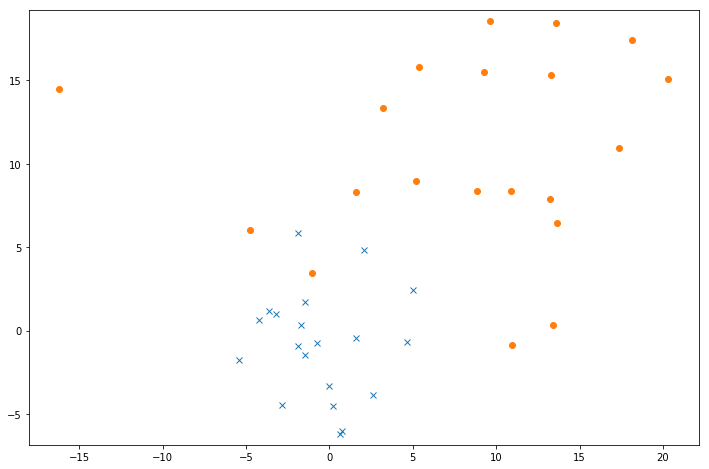

In [16]:
#import matplotlib.pyplot as plt
mean1 = np.array([0, 0])
mean2 = mean1  + 10 
cov1 = [[10, 0], [0, 10]]  # diagonal covariance
cov2 = [[100, 0], [0, 30]]  # diagonal covariance

x1, y1 = np.random.multivariate_normal(mean1, cov1, 20).T
x2, y2 = np.random.multivariate_normal(mean2, cov2, 20).T
A = np.c_[x1,y1]
Y_1 = np.zeros((A.shape[0],1))
B = np.c_[x2,y2]
Y_2 = np.ones((B.shape[0],1))
C = np.vstack((A,B))
Y_C = np.vstack((Y_1,Y_2))
plt.plot(x1, y1, 'x')
plt.plot(x2, y2, 'o')

plt.axis('equal')
plt.show()

In [236]:
learning_rate = 0.001
reg_param  = 0.000005
#X = np.array([[0,0],[0.6,0.2],[1,1],[2,7],[4.2,3.14],[7,40],[3,20],[1,15]])
X = C
y_true = Y_C
X_norm = (X - np.mean(X,axis =0, keepdims = True)) / np.std(X, axis = 0, keepdims = True)

#y_true = np.array([0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0]).reshape(8,1)
y_true_sm = y_true.astype(int)

In [253]:
SL0 = linear_unit(name="S-L0", n_in = 2, n_out = 8)
SA0 = RELU(name ="S-A0", previous_layer=SL0)
D0 = DROPOUT(name="D0", probability=0.9, previous_layer=SA0)
SL1 = linear_unit(name="S-L0", n_in = 8, n_out = 2, previous_layer= D0)
#SA1 = RELU(name ="S-A0", previous_layer=SL1)
softmax_net = NN_softmax(name = "A-fin", previous_layer=SL1)

S-L0 layer size 2x8
Activation S-A0 : RELU
Activation D0 : Dropout with proba: 0.90
S-L0 layer size 8x2
Activation A-fin : softmax


In [254]:
loss_hist, pred, gr = iterate_chain_net_with_softmax(
    net=softmax_net,
    X=X_norm,
    y=y_true_sm,
    lr=learning_rate,
    reg=reg_param,
    shapshot_iteration = 500,
    iterations=10000)

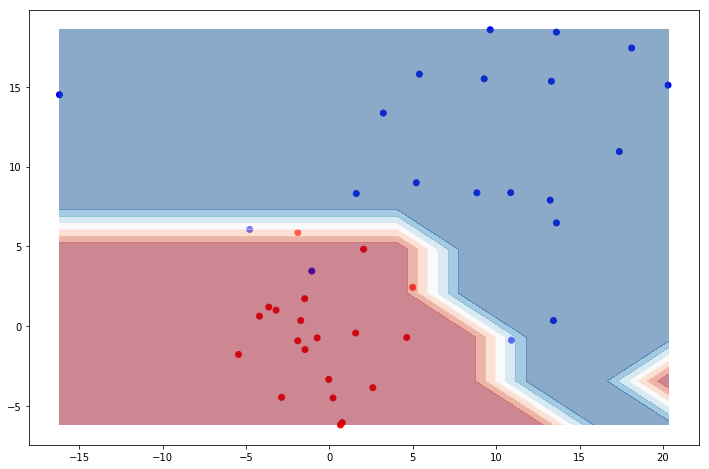

In [255]:
#print (np.argmax(softmax_net.forward(X_norm),axis =1))
#print (softmax_net.forward(X_norm))
show_class_result(network = softmax_net, X = X, y = y_true)


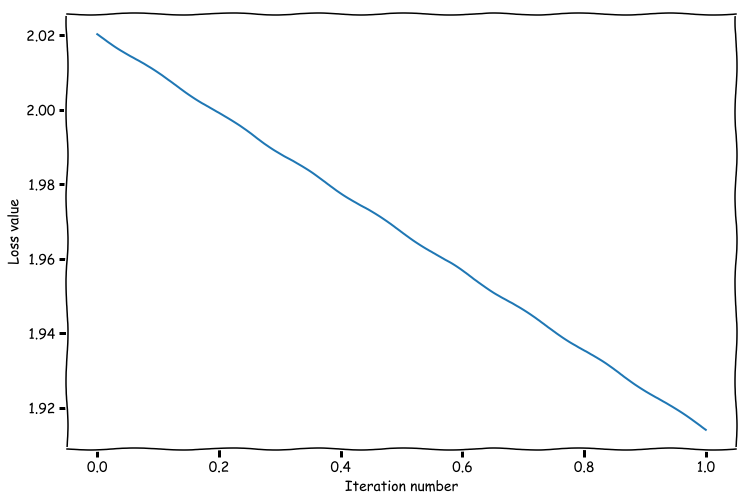

In [234]:
# Хорошая идея для отладки -- нарисовать график отношения функци потерь к номеру итерации 
with plt.xkcd():
    plt.plot(loss_hist[0:])
    plt.xlabel('Iteration number')
    plt.ylabel('Loss value')
    plt.show()

In [22]:
#chain activation test
ch_L0 =  linear_unit(name="chain_L0", n_in = 2, n_out = 4)
ch_A0 =  RELU(name ="chain_A0", previous_layer=ch_L0)
ch_L1 = linear_unit(name="chain_L1", n_in = 4, n_out = 1,previous_layer=ch_A0)
chain_NN =  sigmoid(name ="chain_A1", previous_layer=ch_L1)

chain_L0 layer size 2x4
Activation chain_A0 : RELU
chain_L1 layer size 4x1
Activation chain_A1 : sigmoid


In [23]:
loss_hist, pred, gr  = iterate_chain_net(net=chain_NN, X=X_norm, y=y_true, lr=learning_rate, reg=reg_param, iterations = 10000)

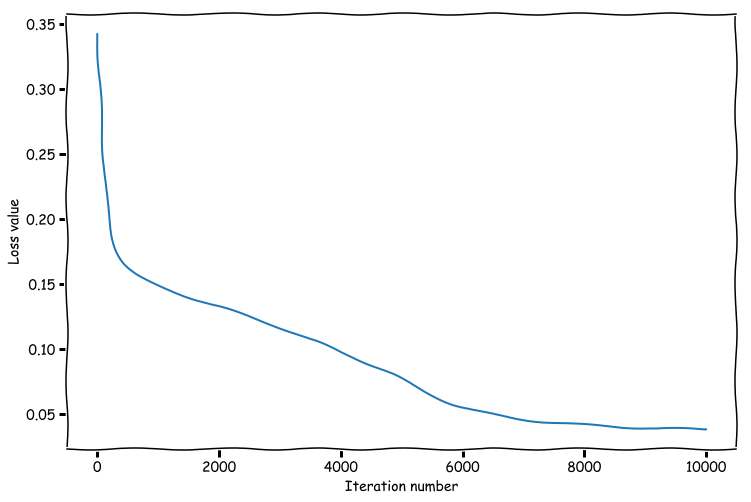

In [24]:
# Хорошая идея для отладки -- нарисовать график отношения функци потерь к номеру итерации 
with plt.xkcd():
    plt.plot(loss_hist)
    plt.xlabel('Iteration number')
    plt.ylabel('Loss value')
    plt.show()

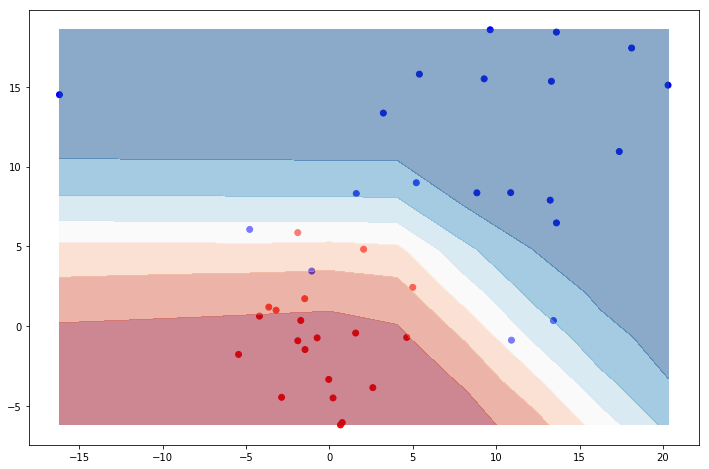

In [25]:
show_class_result(network = chain_NN, X = X, y = y_true, multy_class=False, show=True)

In [26]:
class BatchGen:
    def __init__(self, total_examples, batch_size=32):
        self.ix = np.random.permutation(np.array(range(total_examples)))
        self.batch_ix = 0
        self.batch_size = batch_size
        self.total_examples = total_examples
        return

    def nextBatch(self):
        result = self.ix[self.batch_ix:self.batch_ix + self.batch_size]
        self.batch_ix += self.batch_size
        if self.batch_ix >=self.total_examples:
            self.batch_ix = 0 
        return result
    

In [27]:
BG = BatchGen(total_examples=32, batch_size=7)


In [28]:
for i in range(7):
    print(BG.nextBatch())

[29  4 20 30 11 24 13]
[12  9 16 23 14  1 17]
[ 7 26 25  6 22 18  3]
[19  2 27 31  8  0 28]
[15 10 21  5]
[29  4 20 30 11 24 13]
[12  9 16 23 14  1 17]


In [58]:
class TwoLayerNet(object):
    # В конструкторе зададим все веса, которые нам понадобятся
    def __init__(self, input_size, hidden_size, output_size, std=1e-4, drop_probability=1):
        """
        W1: Первый слой с размерами (D, H)
        b1: Вектор сдвигов, размер  (H,)
        W2: Второй слой с размерами (H, C)
        b2: Вектор сдвигов, размер (C,)

        Входные парамерты:
        - input_size: Размерность входных данных
        - hidden_size: Размер скрытого слоя
        - output_size: Количество классов
        """
        self.params = {}
        self.params['W1'] = std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

        self.L1 = linear_unit(n_in=input_size, n_out=hidden_size, name="L1")
        self.A0 = RELU(name="A0", previous_layer=self.L1)
        self.D0 = DROPOUT(name = "D0", probability=drop_probability, previous_layer=self.A0 )
        self.L2 = linear_unit(
            n_in=hidden_size,
            n_out=output_size,
            name="L2",
            previous_layer=self.D0)
        self.net = NN_softmax(name="A1", previous_layer=self.L2)

    def loss(self, X, y=None, reg=0.0):
        """
        Вычисление функции потерь

        Входные парамерты:
        - X: Таблица данных (N, D). X[i] - один пример
        - y: Вектор лейблов. Если отсутсвует, то возвращается предсказание лейблов
        - reg: Коэффициент регуляризации

        Возвращает:
        Если y == None, то возвращаются оценка (score) для классов

        Если y != None, то возвращаются:
        - Значение функции потерь для данного семпла данных
        - grads: Словарь градиентов, ключи соответствуют ключам словаря self.params.
        """
        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']
        N, D = X.shape

        scores = self.net.forward(X)

        # Расчет forward pass или прямой проход, для данных находятся оценки (scores),
        # Выходная размерность (N, C), количество объектов на количество классов
        # Впишите свой код на место заглушки

        #pass

        # Если y == None, то завершаем вызов
        if y is None:
            return scores

        loss = loss_cross_entropy(scores, y)
        # Расчет cross entropy loss, на выходе должен получиться скаляр
        # Впишите свой код на место заглушки
        #pass

        grads = {}
        # Расчет обратнохо прохода или backward pass, находятся градиенты для всех параметров,
        # результаты сохраняются в grads, например grads['W1']
        # Впишите свой код на место заглушки
        #pass
        

        return loss, grads

    def train(self,
              X,
              y,
              X_val,
              y_val,
              learning_rate=1e-3,
              learning_rate_decay=0.95,
              reg=5e-6,
              num_iters=100,
              batch_size=200,
              verbose=False,
             early_stop = 1e-4):
        """
        Обучение нейронной сети с помощью SGD

        Входные парамерты:
        - X: Матрица данных (N, D)
        - y: Вектор лейблов (N, )
        - X_val: Данные для валидации (N_val, D)
        - y_val: Вектор лейблов валидации (N_val, )
        - reg: Коэффициент регуляризации
        - num_iters: Количнство итераций
        - batch_size: Размер семпла данных, на 1 шаг алгоритма
        - verbose: Вывод прогресса
        """
        num_train = X.shape[0]
        #тут в коде была ошибка max(num_train / batch_size, 1)
        iterations_per_epoch = max(num_train // batch_size, 1)
        print("iter pre epoch", iterations_per_epoch)
        loss_history = []
        train_acc_history = []
        val_acc_history = []

        epoch_passed = False
        BatGen = BatchGen(total_examples=num_train,batch_size = batch_size)

        for it in range(num_iters):

            X_batch = None
            y_batch = None

            # Выбираем минибатч из выборки и заполняем X_batch и y_batch
            # Впишите свой код на место заглушки
            b_ix = BatGen.nextBatch()
            X_batch = X[b_ix, :]
            y_batch = y[b_ix]

            #pass

            # Производим рассчёт значения функции потерь и градиентов
            loss, grads = self.loss(X_batch, y=y_batch, reg=reg)
            if (it > 100) & (epoch_passed):

                if (np.abs(np.mean(loss_history[-16:]) - np.mean(loss_history[-8:])) <
                        early_stop):
                    print(
                        "Early stop at iteration {0}, last 16 loss mean = {1:.6f}, last 8 loss mean = {2:.6f}".
                        format(it,np.mean(loss_history[-16:]), np.mean(loss_history[-8:])))
                    return {
                        'loss_history': loss_history,
                        'train_acc_history': train_acc_history,
                        'val_acc_history': val_acc_history,
                    }
            loss_history.append(loss)

            # Используя градиенты из grads обновите параметры сети.
            # Hint: ключи в словарях градиентов и параметров должны совпадать, можно по ним проитерировать
            # Впишите свой код на место заглушки
            self.net.backward_cross_entropy(
                y=y_batch, lr=learning_rate, reg=reg)
            #pass

            if verbose and (it - 5) % 100 == 0:
                #print(f'iteration {it}/{num_iters}: loss {loss:.4f}')
                lm = np.mean(loss_history[-5:])
                print('iteration {0}/{1}: mean last 5 loss {2:.7f}'.format(
                    it, num_iters, lm))

            if it % iterations_per_epoch == 0:

                train_acc = (self.predict(X_batch) == y_batch).mean()
                val_acc = (self.predict(X_val) == y_val).mean()
                train_acc_history.append(train_acc)
                val_acc_history.append(val_acc)

                # Уменьшаем learning rate
                learning_rate *= learning_rate_decay

                #
                epoch_passed = True

        return {
            'loss_history': loss_history,
            'train_acc_history': train_acc_history,
            'val_acc_history': val_acc_history
        }

    def predict(self, X):
        """
        Входные параметры:
        - X: Матрица данных (N, D)

        Возвращает:
        - y_pred: Вектор предсказаний классов для обьектов (N,)
        """
        y_pred = np.argmax(self.net.forward(X), axis=1)

        # Предсказание классов для обьектов из X
        # Впишите свой код на место заглушки
        #pass

        return y_pred

# Тестируем написанный код

Ниже приведена функция, осуществляющая численную проверку градиента.

In [30]:
def rel_error(x, y):
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y)))) 

def eval_numerical_gradient(f, x, verbose=True, h=0.00001):
    
    fx = f(x)
    grad = np.zeros_like(x)
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:

        ix = it.multi_index
        oldval = x[ix]
        x[ix] = oldval + h 
        fxph = f(x) 
        x[ix] = oldval - h
        fxmh = f(x) 
        x[ix] = oldval 

        # Вычисляем частную производную
        grad[ix] = (fxph - fxmh) / (2 * h) 
        if verbose:
            print(ix, grad[ix])
        it.iternext() 

    return grad

Сгенерируем простые данные и выполним тест.

In [59]:
input_size = 4
hidden_size = 10
num_classes = 3
num_inputs = 5

def init_toy_model():
    np.random.seed(0)
    return TwoLayerNet(input_size, hidden_size, num_classes, std=1e-1)

def init_toy_data():
    np.random.seed(1)
    X = 10 * np.random.randn(num_inputs, input_size)
    y = np.array([0, 1, 2, 2, 1])
    return X, y

net = init_toy_model()
X_toy, y_toy = init_toy_data()

L1 layer size 4x10
Activation A0 : RELU
Activation D0 : Dropout with proba: 1.00
L2 layer size 10x3
Activation A1 : softmax


## Не будем этого делать, сетка работает :)

In [60]:

#loss, grads = net.loss(X_toy, y_toy, reg=0.05)

# Ошибка должна быть меньше или около 1e-8
#for param_name in grads:
#    f = lambda _: net.loss(X_toy, y_toy, reg=0.05)[0] # функция не использует аргумент, это нормально :)
#    param_grad_num = eval_numerical_gradient(f, net.params[param_name], verbose=False)
#    print('%s max relative error: %e' % (param_name, rel_error(param_grad_num, grads[param_name])))

Реализуйте метод `TwoLayerNet.train` и метод `TwoLayerNet.predict`

Обучите сеть на игрушечных данных, которые мы сгенерировали выше, значение функции потерь дольжно быть меньше или около $0.2$.

L1 layer size 4x10
Activation A0 : RELU
Activation D0 : Dropout with proba: 1.00
L2 layer size 10x3
Activation A1 : softmax
iter pre epoch 1
Final training loss:  0.004497565892272254


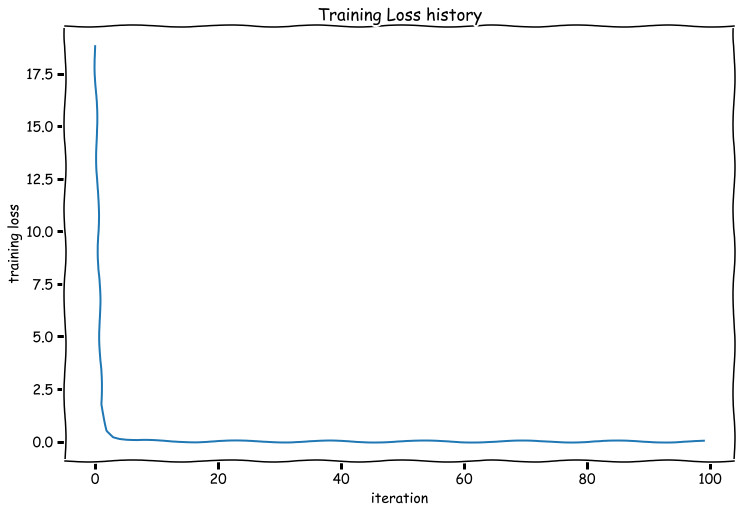

In [61]:
net = init_toy_model()
stats = net.train(X_toy, y_toy, X_toy, y_toy,
            learning_rate=1e-1, reg=5e-6,
            num_iters=100, verbose=False)

print('Final training loss: ', stats['loss_history'][-1])
with plt.xkcd():
    plt.plot(stats['loss_history'])
    plt.xlabel('iteration')
    plt.ylabel('training loss')
    plt.title('Training Loss history')
    plt.show()

# Обучение сети
Теперь, когда всё готово, вы можете обучить сеть на данных CIFAR-10

In [34]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

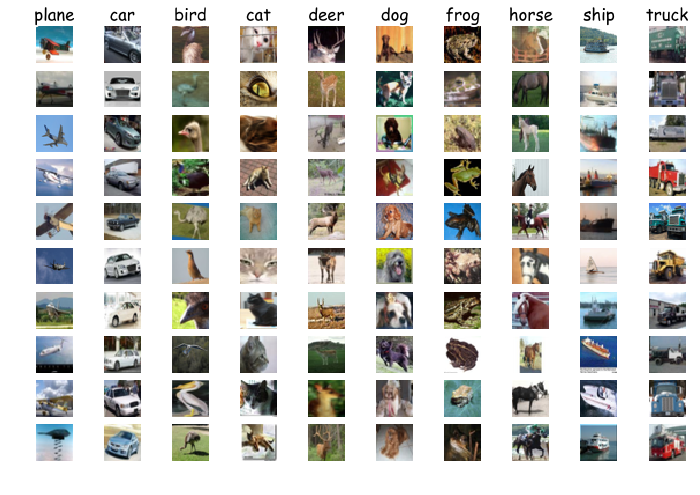

In [35]:
with plt.xkcd():
    classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    num_classes = len(classes)
    samples_per_class = 10
    for y, cls in enumerate(classes):
        idxs = np.flatnonzero(y_train == y)
        idxs = np.random.choice(idxs, samples_per_class, replace=False)
        for i, idx in enumerate(idxs):
            plt_idx = i * num_classes + y + 1
            plt.subplot(samples_per_class, num_classes, plt_idx)
            plt.imshow(x_train[idx].astype('uint8'))
            plt.axis('off')
            if i == 0:
                plt.title(cls)
    plt.show()

In [36]:
# Preprocessing: преобразуем изображения к плоскому виду
x_train = np.reshape(x_train, (x_train.shape[0], -1))
x_test = np.reshape(x_test, (x_test.shape[0], -1))
y_train = np.squeeze(y_train, 1)
y_test = np.squeeze(y_test, 1)


# Печатаем размерности, чтобы проверить что мы не ошиблись
print('Training data shape: ', x_train.shape)
print('Test data shape: ', x_test.shape)

Training data shape:  (50000, 3072)
Test data shape:  (10000, 3072)


[130.71074 136.05614 132.5538  130.14036 135.44238 131.85358 131.05044
 136.24616 132.58144 131.56886]


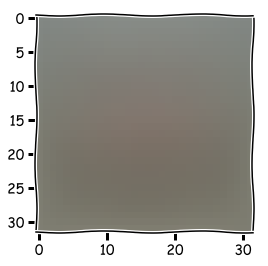

In [37]:
# Preprocessing: вычитаем среднее
# 1: Находим среднее изображение
mean_image = np.mean(x_train, axis=0)
print(mean_image[:10]) # для проверки напечаем несколько элементов
with plt.xkcd():
    plt.figure(figsize=(4,4))
    plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # визуализируем полученное среднее
    plt.show()

In [38]:
# 2: вычитаем среднее из изображений обучающей и тестовых выборок
x_train = x_train - mean_image
x_test = x_test - mean_image

In [39]:
n_samples = x_train.shape[0]
x_val, y_val = x_train[:int(n_samples*0.05)], y_train[:int(n_samples*0.05)]
x_train, y_train = x_train[int(n_samples*0.05):], y_train[int(n_samples*0.05):]

In [65]:
input_size = 32 * 32 * 3
hidden_size = 64
num_classes = 10
drop_prop = 1

net = TwoLayerNet(input_size, hidden_size, num_classes, drop_probability=drop_prop)

stats = net.train(x_train, y_train, x_val, y_val,
            num_iters=5000, batch_size=16,
            learning_rate=1e-3, learning_rate_decay=0.95,
            reg=0.0005, verbose=True,early_stop = 1e-6)

val_acc = (net.predict(x_val) == y_val).mean()
print('Validation accuracy: ', val_acc)

L1 layer size 3072x64
Activation A0 : RELU
Activation D0 : Dropout with proba: 1.00
L2 layer size 64x10
Activation A1 : softmax
iter pre epoch 2968
iteration 5/5000: mean last 5 loss 120.7528347
iteration 105/5000: mean last 5 loss 45.2596266
iteration 205/5000: mean last 5 loss 34.8370763
iteration 305/5000: mean last 5 loss 24.9997242
iteration 405/5000: mean last 5 loss 20.1487460
iteration 505/5000: mean last 5 loss 14.6201814
iteration 605/5000: mean last 5 loss 11.7264049
iteration 705/5000: mean last 5 loss 11.1485249
iteration 805/5000: mean last 5 loss 7.7702395
iteration 905/5000: mean last 5 loss 7.8492723
iteration 1005/5000: mean last 5 loss 5.9404188
iteration 1105/5000: mean last 5 loss 4.4157116
iteration 1205/5000: mean last 5 loss 3.8757238
iteration 1305/5000: mean last 5 loss 2.7317737
iteration 1405/5000: mean last 5 loss 2.8163026
iteration 1505/5000: mean last 5 loss 2.4360511
iteration 1605/5000: mean last 5 loss 2.1061614
iteration 1705/5000: mean last 5 loss 2

# Дебаг процесса обучения

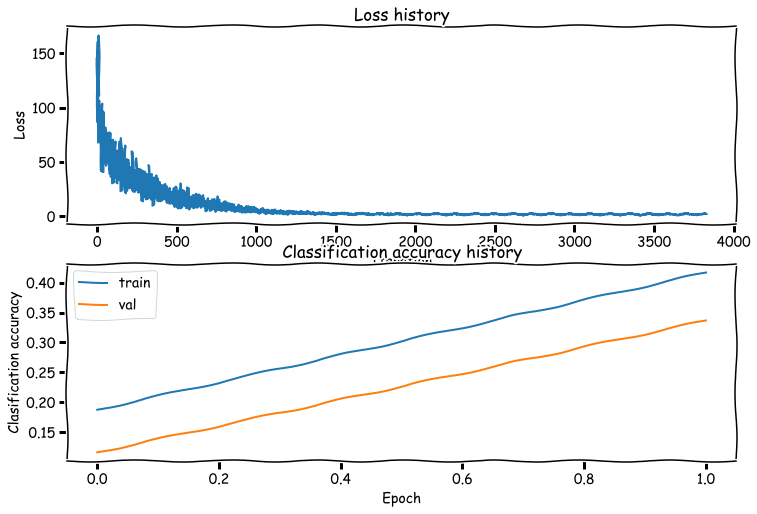

In [66]:
with plt.xkcd():
    plt.subplot(2, 1, 1)
    plt.plot(stats['loss_history'])
    plt.title('Loss history')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')

    plt.subplot(2, 1, 2)
    t_acc = plt.plot(stats['train_acc_history'], label='train')
    v_acc = plt.plot(stats['val_acc_history'], label='val')
    plt.legend()
    plt.title('Classification accuracy history')
    plt.xlabel('Epoch')
    plt.ylabel('Clasification accuracy')
    plt.show()

# Настройка гиперпараметров

In [103]:
best_net = None

net_exam_amount = 10

hidden_sizes = np.random.permutation(np.array(range(10, 300,
                                                    10)))[:net_exam_amount]

input_size = 32 * 32 * 3
#hidden_size = 64
num_classes = 10
drop_prop = 1

net_zoo = []
param_desc = []
stats = []
accuracy_list = []

for h in hidden_sizes:
    net_zoo.append(
        TwoLayerNet(input_size, h, num_classes, drop_probability=drop_prop))
    param_desc.append({'hidden': h,'dropout':drop_prop, 'regular':0.0005})

for animal in net_zoo:
    stats.append(
        animal.train(
            x_train,
            y_train,
            x_val,
            y_val,
            num_iters=5000,
            batch_size=16,
            learning_rate=1e-4,
            learning_rate_decay=0.95,
            reg=0.0005,
            verbose=False,
            early_stop=1e-5))

    accuracy_list.append( (animal.predict(x_val) == y_val).mean())
    #print(stats.size,'Validation accuracy: ', val_acc)


L1 layer size 3072x70
Activation A0 : RELU
Activation D0 : Dropout with proba: 1.00
L2 layer size 70x10
Activation A1 : softmax
L1 layer size 3072x290
Activation A0 : RELU
Activation D0 : Dropout with proba: 1.00
L2 layer size 290x10
Activation A1 : softmax
L1 layer size 3072x50
Activation A0 : RELU
Activation D0 : Dropout with proba: 1.00
L2 layer size 50x10
Activation A1 : softmax
L1 layer size 3072x110
Activation A0 : RELU
Activation D0 : Dropout with proba: 1.00
L2 layer size 110x10
Activation A1 : softmax
L1 layer size 3072x210
Activation A0 : RELU
Activation D0 : Dropout with proba: 1.00
L2 layer size 210x10
Activation A1 : softmax
L1 layer size 3072x60
Activation A0 : RELU
Activation D0 : Dropout with proba: 1.00
L2 layer size 60x10
Activation A1 : softmax
L1 layer size 3072x140
Activation A0 : RELU
Activation D0 : Dropout with proba: 1.00
L2 layer size 140x10
Activation A1 : softmax
L1 layer size 3072x100
Activation A0 : RELU
Activation D0 : Dropout with proba: 1.00
L2 layer si

In [104]:
def param_to_str(param):
    return "Network with {0} hidden size".format(param['hidden'])

In [105]:
param_to_str(param_desc[0])

'Network with 70 hidden size'

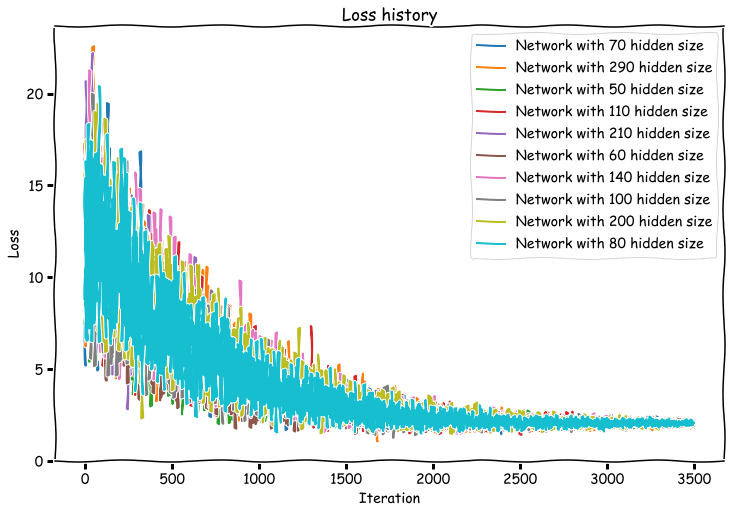

In [108]:

with plt.xkcd():
    #plt.subplot(2, 1, 1)
    i = 0
    for s in stats:
        plt.plot(s['loss_history'][1500:], label = param_to_str(param_desc[i]))
        i += 1
    plt.title('Loss history')
    
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.show()
    

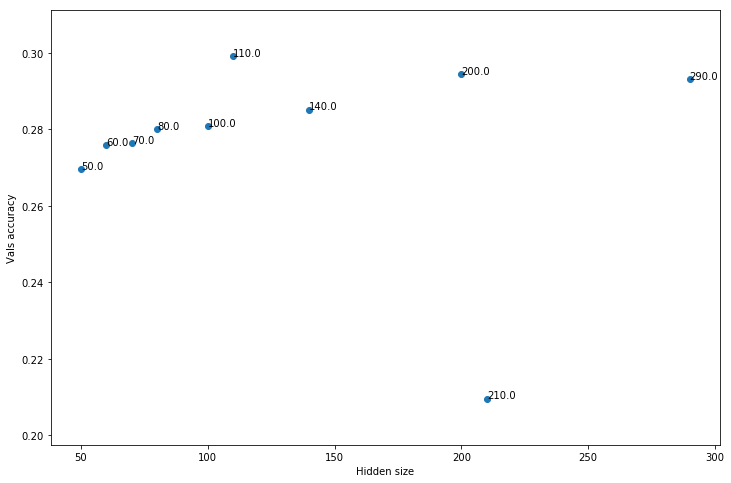

In [122]:
l = np.vstack((np.array(accuracy_list), hidden_sizes)).T

fig, ax = plt.subplots()
ax.scatter(l[:,1], l[:,0])
plt.xlabel('Hidden size')
plt.ylabel('Vals accuracy')

for i, txt in enumerate(l[:,1]):
    ax.annotate(txt, (l[i,1], l[i,0]))

#### Зафиксируем в скрытом слое 110 нейронов, вернее лучше будет, если возьмём 128

In [171]:
def param_to_str(param):
    return "Network hidden:{0} drop:{1:.2f} reg:{2:.8f}, lr:{3:.7f}, lr dec:{4:.2f}, batch:{5}".format(
        param['hidden'], param['dropout'], param['regular'], param['learn_rate'], param['learn_rate_dec'],param['batch'])

In [169]:
#net_exam_amount = 10

input_size = 32 * 32 * 3
hidden_size = 110
num_classes = 10

drop_prop_list = [0.8, 0.85, 0.9]

reg_list = np.power(10, -3 * np.random.random(2) - 4)
batch_size_list = [16,32]
learning_rate_decay_list = [0.95]
learning_rate_list = np.power(10, -2 * np.random.random(3) - 4)

net_zoo = []
param_desc = []
stats = []
accuracy_list = []

counter = 1

t0 = time.time()
for d in drop_prop_list:
    for r in reg_list:
        for b in batch_size_list:
            for lr in learning_rate_list:
                for lr_d in learning_rate_decay_list:
                    
                    net_zoo.append(
                        TwoLayerNet(input_size, hidden_size, num_classes, drop_probability=d))
                    param_desc.append({'hidden': hidden_size, 'dropout':d, 'regular':r ,'learn_rate':lr,'learn_rate_dec':lr_d,'batch':b})
                    animal = net_zoo[-1]
                    stats.append(
                        animal.train(
                            x_train,
                            y_train,
                            x_val,
                            y_val,
                            num_iters=10000,
                            batch_size=b,
                            learning_rate=lr,
                            learning_rate_decay=lr_d,
                            reg=r,
                            verbose=False,
                            early_stop=1e-5))
                    accuracy_list.append((animal.predict(x_val) == y_val).mean())
                    print ("Time per iteraton: {0:.1f} sec", (time.time() - t0 )/counter)
                    counter += 1
    #print(stats.size,'Validation accuracy: ', val_acc)

L1 layer size 3072x110
Activation A0 : RELU
Activation D0 : Dropout with proba: 0.80
L2 layer size 110x10
Activation A1 : softmax
iter pre epoch 2968


C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:10: RuntimeWarning: divide by zero encountered in log
C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:136: RuntimeWarning: invalid value encountered in double_scalars


Time per iteraton: {0:.1f} sec 153.7590000629425
L1 layer size 3072x110
Activation A0 : RELU
Activation D0 : Dropout with proba: 0.80
L2 layer size 110x10
Activation A1 : softmax
iter pre epoch 2968
Time per iteraton: {0:.1f} sec 139.63550007343292
L1 layer size 3072x110
Activation A0 : RELU
Activation D0 : Dropout with proba: 0.80
L2 layer size 110x10
Activation A1 : softmax
iter pre epoch 2968
Time per iteraton: {0:.1f} sec 133.3653333981832
L1 layer size 3072x110
Activation A0 : RELU
Activation D0 : Dropout with proba: 0.80
L2 layer size 110x10
Activation A1 : softmax
iter pre epoch 1484
Time per iteraton: {0:.1f} sec 131.15100002288818
L1 layer size 3072x110
Activation A0 : RELU
Activation D0 : Dropout with proba: 0.80
L2 layer size 110x10
Activation A1 : softmax
iter pre epoch 1484
Time per iteraton: {0:.1f} sec 140.2528000354767
L1 layer size 3072x110
Activation A0 : RELU
Activation D0 : Dropout with proba: 0.80
L2 layer size 110x10
Activation A1 : softmax
iter pre epoch 1484
Tim

In [178]:
for k in learning_rate_list:
    print(k)

1.94114004004814e-06
1.5718404080640657e-06
1.8284032539581389e-06


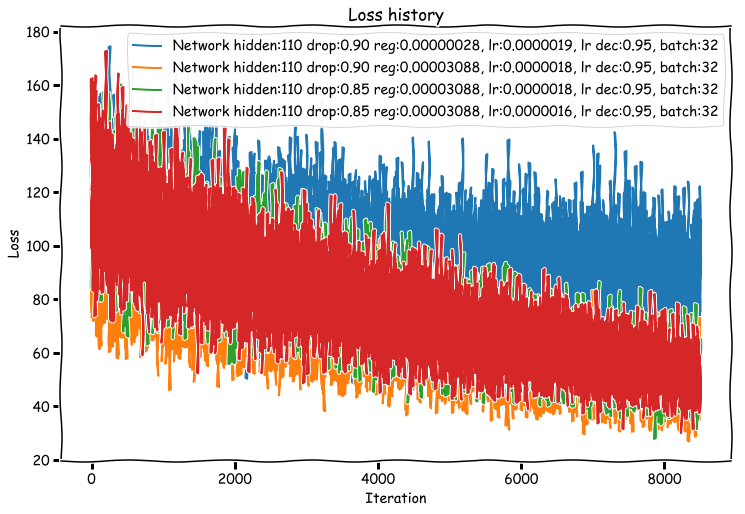

In [180]:

with plt.xkcd():
    #plt.subplot(2, 1, 1)
    i = 0
    for s in np.argsort(accuracy_list)[::-1][:4]:
        plt.plot(stats[s]['loss_history'][1500:], label = param_to_str(param_desc[s]))
        i += 1
    plt.title('Loss history')
    
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.show()

In [179]:
for n in np.argsort(accuracy_list)[::-1][:4]:
    print (param_to_str(param_desc[n]), accuracy_list[n])

Network hidden:110 drop:0.90 reg:0.00000028, lr:0.0000019, lr dec:0.95, batch:32 0.152
Network hidden:110 drop:0.90 reg:0.00003088, lr:0.0000018, lr dec:0.95, batch:32 0.1456
Network hidden:110 drop:0.85 reg:0.00003088, lr:0.0000018, lr dec:0.95, batch:32 0.136
Network hidden:110 drop:0.85 reg:0.00003088, lr:0.0000016, lr dec:0.95, batch:32 0.1356


In [181]:
#net_exam_amount = 10

input_size = 32 * 32 * 3
hidden_size = 110
num_classes = 10

drop_prop_list = [0.9]

reg_list = [0.00000028]
batch_size_list = [32]
learning_rate_decay_list = [0.95]
learning_rate_list = np.power(10, -4 * np.random.random(5) - 2)

net_zoo = []
param_desc = []
stats = []
accuracy_list = []

counter = 1

t0 = time.time()
for d in drop_prop_list:
    for r in reg_list:
        for b in batch_size_list:
            for lr in learning_rate_list:
                for lr_d in learning_rate_decay_list:
                    
                    net_zoo.append(
                        TwoLayerNet(input_size, hidden_size, num_classes, drop_probability=d))
                    param_desc.append({'hidden': hidden_size, 'dropout':d, 'regular':r ,'learn_rate':lr,'learn_rate_dec':lr_d,'batch':b})
                    animal = net_zoo[-1]
                    stats.append(
                        animal.train(
                            x_train,
                            y_train,
                            x_val,
                            y_val,
                            num_iters=10000,
                            batch_size=b,
                            learning_rate=lr,
                            learning_rate_decay=lr_d,
                            reg=r,
                            verbose=False,
                            early_stop=1e-5))
                    accuracy_list.append((animal.predict(x_val) == y_val).mean())
                    print ("Time per iteraton: {0:.1f} sec", (time.time() - t0 )/counter)
                    counter += 1
    #print(stats.size,'Validation accuracy: ', val_acc)

L1 layer size 3072x110
Activation A0 : RELU
Activation D0 : Dropout with proba: 0.90
L2 layer size 110x10
Activation A1 : softmax
iter pre epoch 1484
Time per iteraton: {0:.1f} sec 136.27300000190735
L1 layer size 3072x110
Activation A0 : RELU
Activation D0 : Dropout with proba: 0.90
L2 layer size 110x10
Activation A1 : softmax
iter pre epoch 1484


C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:10: RuntimeWarning: divide by zero encountered in log
C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:136: RuntimeWarning: invalid value encountered in double_scalars


Time per iteraton: {0:.1f} sec 132.26950001716614
L1 layer size 3072x110
Activation A0 : RELU
Activation D0 : Dropout with proba: 0.90
L2 layer size 110x10
Activation A1 : softmax
iter pre epoch 1484
Time per iteraton: {0:.1f} sec 134.32433334986368
L1 layer size 3072x110
Activation A0 : RELU
Activation D0 : Dropout with proba: 0.90
L2 layer size 110x10
Activation A1 : softmax
iter pre epoch 1484
Time per iteraton: {0:.1f} sec 136.58649998903275
L1 layer size 3072x110
Activation A0 : RELU
Activation D0 : Dropout with proba: 0.90
L2 layer size 110x10
Activation A1 : softmax
iter pre epoch 1484
Time per iteraton: {0:.1f} sec 136.61440000534057


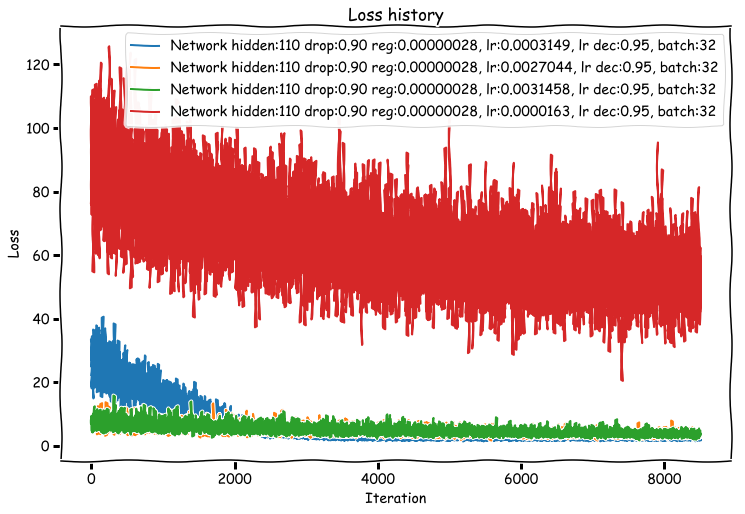

In [182]:

with plt.xkcd():
    #plt.subplot(2, 1, 1)
    i = 0
    for s in np.argsort(accuracy_list)[::-1][:4]:
        plt.plot(stats[s]['loss_history'][1500:], label = param_to_str(param_desc[s]))
        i += 1
    plt.title('Loss history')
    
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.show()

In [183]:
for n in np.argsort(accuracy_list)[::-1][:4]:
    print (param_to_str(param_desc[n]), accuracy_list[n])

Network hidden:110 drop:0.90 reg:0.00000028, lr:0.0003149, lr dec:0.95, batch:32 0.3208
Network hidden:110 drop:0.90 reg:0.00000028, lr:0.0027044, lr dec:0.95, batch:32 0.2708
Network hidden:110 drop:0.90 reg:0.00000028, lr:0.0031458, lr dec:0.95, batch:32 0.228
Network hidden:110 drop:0.90 reg:0.00000028, lr:0.0000163, lr dec:0.95, batch:32 0.2172


In [257]:
input_size = 32 * 32 * 3
hidden_size = 110
num_classes = 10
drop_prop = 0.9

net = TwoLayerNet(input_size, hidden_size, num_classes, drop_probability=drop_prop)

stats = net.train(x_train, y_train, x_val, y_val,
            num_iters=15000, batch_size=32,
            learning_rate=0.0003149, learning_rate_decay=0.95,
            reg=0.00000028, verbose=True,early_stop = 1e-6)

val_acc = (net.predict(x_val) == y_val).mean()
print('Validation accuracy: ', val_acc)

L1 layer size 3072x110
Activation A0 : RELU
Activation D0 : Dropout with proba: 0.90
L2 layer size 110x10
Activation A1 : softmax
iter pre epoch 1484
iteration 5/15000: mean last 5 loss 159.8761666
iteration 105/15000: mean last 5 loss 70.5953549
iteration 205/15000: mean last 5 loss 66.2272418
iteration 305/15000: mean last 5 loss 56.5167086
iteration 405/15000: mean last 5 loss 53.5979723
iteration 505/15000: mean last 5 loss 46.7782715
iteration 605/15000: mean last 5 loss 46.7363782
iteration 705/15000: mean last 5 loss 51.8476206
iteration 805/15000: mean last 5 loss 42.1031724
iteration 905/15000: mean last 5 loss 36.0030654
iteration 1005/15000: mean last 5 loss 41.4065620
iteration 1105/15000: mean last 5 loss 37.0652150
iteration 1205/15000: mean last 5 loss 34.7061307
iteration 1305/15000: mean last 5 loss 26.1756070
iteration 1405/15000: mean last 5 loss 24.8287613
iteration 1505/15000: mean last 5 loss 28.1776038
iteration 1605/15000: mean last 5 loss 27.6379307
iteration 1

# Проверка качества
С оптимальными гиперпараметрами сеть должна выдавать точнов около 48%.

In [259]:
test_acc = (net.predict(x_test) == y_test).mean()
print('Test accuracy: ', test_acc)

Test accuracy:  0.3217


P.s. Уже после того, как параметры подобрались, выяснилось, что в классе DROPOUT в backprop была ошибка. Градиент не домножался на 1/p, финальный прогон сделан с учётом её коррекции. 